In [1]:
import pickle
import os.path
import argparse
from matplotlib import  pyplot as plt
from utils import *
from attacks import fgsm_grad_sign, vis_fgsm_attack, fgsm_testacc, tensorToImg
from cnnMNIST import CNNMNIST
from resnetCIFAR10 import ResNet18
import random
import utils

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn


dataDir = f'../db'
modelDir = f'./model'
logDir = f'./log'
figDir = f'./fig'
use_cuda = torch.cuda.is_available()
if use_cuda:
    location = 'cuda'
else:
    location = 'cpu'
print(location)

cuda


# MNIST - CNN

In [2]:
torch.manual_seed(1) 
random.seed(1) 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
testset = torchvision.datasets.MNIST(dataDir, train=False,  download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)
nTestSamples, width, height = testset.data.shape
print(f'# test samples:{nTestSamples}')
print(f'per image size: {width}*{height}')

# test samples:10000
per image size: 28*28


In [3]:
net = CNNMNIST()
net.to(location)
criterion = torch.nn.CrossEntropyLoss()
# I trained with torch.nn.DataParallel
net = torch.nn.DataParallel(net)
netname='mnist-cnn'
modelPath = modelDir+ '/best-{}-checkpoint.pth.tar'.format(netname)
checkpoint = torch.load(modelPath, map_location=torch.device(location))
net.load_state_dict(checkpoint['state_dict'])
test_loss, test_accuracy, Ypred = utils._test(net, testloader, criterion, use_cuda, vectorize=False)
    
print(f'For the loaded net: testing loss: {test_loss:5.4f} | testing accuracy:[{test_accuracy:5.4f}]')
print(f"Recorded          : testing loss: {checkpoint['testing_loss_seq'][-1]:5.4f} | testing accuracy:[{checkpoint['testing_accuracy_seq'][-1]:5.4f}]")

For the loaded net: testing loss: 0.0026 | testing accuracy:[0.9873]
Recorded          : testing loss: 0.0026 | testing accuracy:[0.9873]


## FGSM attack: visualization

In [4]:
# get datasamples
for X,y in testloader:
    images, labels = X.to(location), y.to(location)
    break
# get the sign of gradients
grad_sign = fgsm_grad_sign(net, images, labels, criterion)

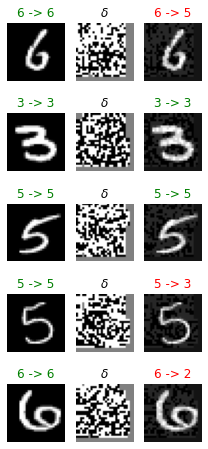

In [5]:
# visualize attacks
vis_fgsm_attack(net, images, labels, grad_sign, epsilon=0.3, M = 5, start=50)

In [6]:
# save figs
for epsilon in [0.0, 0.1, 0.3, 0.5]:
    vis_fgsm_attack(net, images, labels, grad_sign, 
                epsilon=epsilon, M = 5, start=50, savename=f'fgsm-mnist-cnn-{epsilon}', figDir=figDir)

## FGSM attack: measure attack powers

In [7]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = fgsm_testacc(net, testloader, criterion, epsilon, use_cuda)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.987 
epsilon:0.10 | accuracy:0.924 | # adversarial examples:   644
epsilon:0.20 | accuracy:0.756 | # adversarial examples:  2318
epsilon:0.30 | accuracy:0.519 | # adversarial examples:  4698
epsilon:0.40 | accuracy:0.310 | # adversarial examples:  6784
epsilon:0.50 | accuracy:0.167 | # adversarial examples:  8217


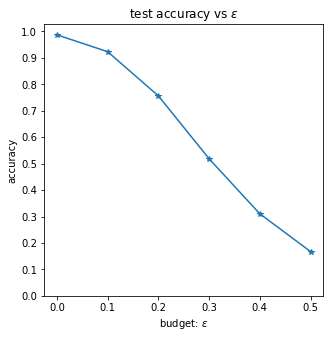

In [8]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, acc_lst, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title(r"test accuracy vs $\varepsilon$")
plt.xlabel(r"budget: $\varepsilon$")
plt.ylabel("accuracy")
plt.show()

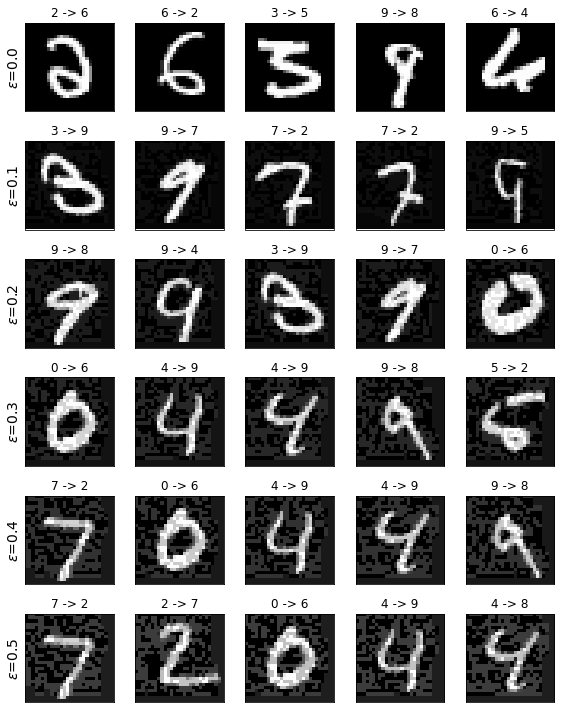

In [9]:
# show adversarial examples
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(adv_imgs[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(adv_imgs[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(r"$\varepsilon$={}".format(epsilons[i]), fontsize=14)
        img,true_label,predicted_label = adv_imgs[i][j]
        plt.title("{} -> {}".format(true_label, predicted_label))
        plt.imshow(img[0], cmap="gray")
plt.tight_layout()
plt.show()

# CIFAR10 - Resnet18 

In [10]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(dataDir, train=False,  download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)
nTestSamples, width, height, channel = testset.data.shape
print(f'# test samples:{nTestSamples}')
print(f'per image size: {width}*{height} | per image channel:{channel}')

# test samples:10000
per image size: 32*32 | per image channel:3


In [11]:
net = ResNet18()
net.to(location)
net = torch.nn.DataParallel(net)
criterion = torch.nn.CrossEntropyLoss()
netname=f'cifar10-resnet'
modelPath = modelDir+ '/best-{}-checkpoint.pth.tar'.format(netname)
checkpoint = torch.load(modelPath, map_location=torch.device(location))
net.load_state_dict(checkpoint['state_dict'])
test_loss, test_accuracy, Ypred = utils._test(net, testloader, criterion, use_cuda, vectorize=False)
print(f'For the loaded net: testing loss: {test_loss:5.4f} | testing accuracy:[{test_accuracy:5.4f}]')
print(f"Recorded          : testing loss: {checkpoint['testing_loss_seq'][-1]:5.4f} | testing accuracy:[{checkpoint['testing_accuracy_seq'][-1]:5.4f}]")

For the loaded net: testing loss: 0.6053 | testing accuracy:[0.9465]
Recorded          : testing loss: 0.6053 | testing accuracy:[0.9465]


## FGSM attack: visualization

In [13]:
# get datasamples
for X,y in testloader:
    images, labels = X.to(location), y.to(location)
    break
# get the sign of gradients
grad_sign = fgsm_grad_sign(net, images, labels, criterion)
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010],
    std=[1/0.2023, 1/0.1994, 1/0.2010])

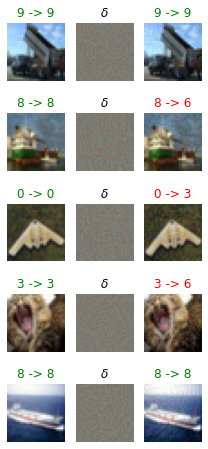

In [14]:
# visualize attacks
vis_fgsm_attack(net, images, labels, grad_sign, epsilon=0.1, figtype='rgb', 
                inv_normalize= inv_normalize, M = 5, start=50, savename=None, figDir=None)

In [15]:
# save figs
for epsilon in [0.0, 0.1, 0.3, 0.5]:
    vis_fgsm_attack(net, images, labels, grad_sign, epsilon=epsilon, figtype='rgb', 
                inv_normalize= inv_normalize, M = 5, start=50, savename=f'fgsm-cifa10-resnet18-{epsilon}', figDir=figDir)

## FGSM attack: measure attack powers

In [23]:
acc_lst = []
epsilons = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
adv_imgs = []
for epsilon in epsilons:
    accuracy, adv_count, adv_examples = fgsm_testacc(net, testloader, criterion, epsilon, use_cuda)
    acc_lst.append(accuracy)
    adv_imgs.append(adv_examples)
    if epsilon != 0.0:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} | # adversarial examples:{adv_count:6d}")
    else:
        print(f"epsilon:{epsilon:3.2f} | accuracy:{accuracy:4.3f} ")

epsilon:0.00 | accuracy:0.947 
epsilon:0.10 | accuracy:0.428 | # adversarial examples:  5200
epsilon:0.20 | accuracy:0.364 | # adversarial examples:  5931
epsilon:0.30 | accuracy:0.285 | # adversarial examples:  6855
epsilon:0.40 | accuracy:0.206 | # adversarial examples:  7744
epsilon:0.50 | accuracy:0.157 | # adversarial examples:  8312


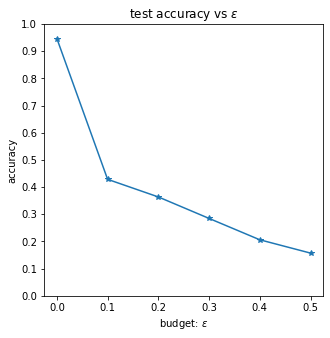

In [24]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, acc_lst, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title(r"test accuracy vs $\varepsilon$")
plt.xlabel(r"budget: $\varepsilon$")
plt.ylabel("accuracy")
plt.show()

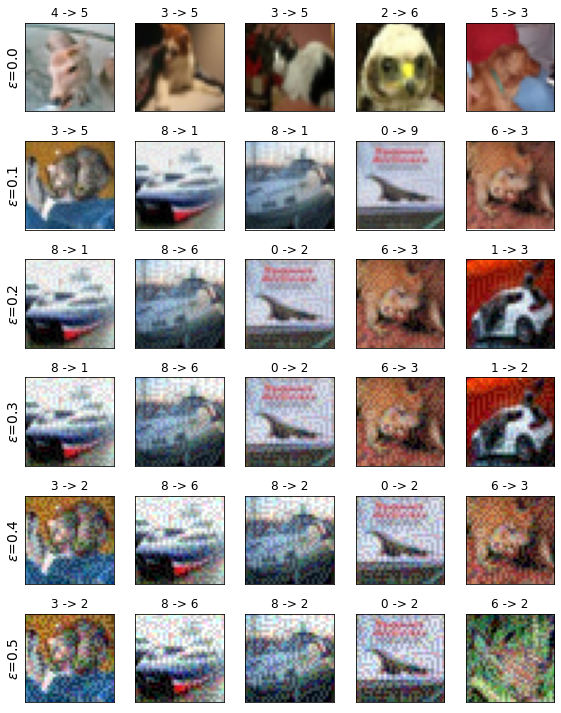

In [25]:
# show adversarial examples
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(adv_imgs[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(adv_imgs[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(r"$\varepsilon$={}".format(epsilons[i]), fontsize=14)
        img,true_label,predicted_label = adv_imgs[i][j]
        plt.title("{} -> {}".format(true_label, predicted_label))
        plt.imshow(tensorToImg(img, inv_normalize))
plt.tight_layout()
plt.show()

In [12]:
# def fgsm(model, X, y, criterion, epsilon):
#     """ Construct FGSM adversarial examples on the examples X"""
#     delta = torch.zeros_like(X, requires_grad=True)
#     loss = criterion(model(X + delta), y)
#     loss.backward()
#     return epsilon * delta.grad.detach().sign()
# def plot_images(img,label,pred,M,N):
#     f,ax = plt.subplots(M,N, sharex=True, sharey=True, figsize=(N,M*1.3))
#     for i in range(M):
#         for j in range(N):
#             ax[i][j].imshow(img[i*N+j][0].cpu().numpy(), cmap="gray")
#             title = ax[i][j].set_title("Pred: {}".format(pred[i*N+j]))
#             plt.setp(title, color=('g' if pred[i*N+j] == label[i*N+j] else 'r'))
#             ax[i][j].set_axis_off()
#     plt.tight_layout()
# prediction = net(images).data.max(1)[1]
# plot_images(images, labels, prediction, 6,4)
# delta = fgsm(net, images, labels, criterion, 0.3)
# plot_images(delta, y, y, 3, 6)
# prediction = net(images+delta).data.max(1)[1]
# plot_images(images+delta, labels, prediction, 6,4)

In [ ]:
# M = 3; start=0; epsilon = 0.3
# delta = epsilon * grad_sign
# images_adv = images + delta
# pred_clean = net(images).data.max(1)[1]
# pred_adv = net(images_adv).data.max(1)[1]
# f,ax = plt.subplots(M,3, sharex=True, sharey=True, figsize=(3,M*1.3))
# for i in range(M):
#     for j in range(3):
#         if j == 0:
#             ax[i][0].imshow(tensorToImg(images[i+start], inv_normalize))
#             title = ax[i][j].set_title(f"{labels[i+start]} -> {pred_clean[i+start]}")
#             plt.setp(title, color=('g' if pred_clean[i+start] == labels[i+start] else 'r'))
#         elif j == 1:
#             ax[i][1].imshow(tensorToImg(delta[i+start], inv_normalize))
#             title = ax[i][j].set_title(r"$\delta$")
#             # plt.setp(title)
#         else:
#             ax[i][2].imshow(tensorToImg(images_adv[i+start], inv_normalize))
#             title = ax[i][j].set_title(f"{labels[i+start]} -> {pred_adv[i+start]}")
#             plt.setp(title, color=('g' if pred_adv[i+start] == labels[i+start] else 'r'))
#         ax[i][j].set_axis_off()
# plt.tight_layout()

In [ ]:
# def tensorToImg(imgTensor, inv_normalize):
#     inv_tensor = inv_normalize(imgTensor)
#     inv_img = (inv_tensor * 255).clamp(0,255)
#     return inv_img.cpu().permute(1,2,0).clone().detach().to(torch.int32)